In [48]:
import json
import os
import pandas as pd
from shoeboxer.schedules import default_schedules
from shoeboxer.batch import batch_sim
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from archetypal import settings
from lightning.pytorch import Trainer

from ml.surrogate import Surrogate
from ml.predict import predict_ubem
from weather.weather import extract
from ladybug.epw import EPW
# import multiple locator from matplotlib
from matplotlib.ticker import MultipleLocator

# Check if we are running on Windows or Linux using os
if os.name == "nt":
    settings.ep_version == "22.2.0"
    settings.energyplus_location = Path("C:/EnergyPlusV22-2-0")
else:
    settings.ep_version == "22.2.0"
    settings.energyplus_location = Path("/usr/local/EnergyPlus-22-2-0")

In [42]:

registry = "ml-for-building-energy-modeling/model-registry"
model = "Global UBEM Shoebox Surrogate with Combined TS Embedder"
tag = "v3"
resource = "model.ckpt"

surrogate = Surrogate.load_from_registry(registry, model, tag, resource)
surrogate.model.eval()

trainer = Trainer(
        accelerator="auto",
        devices="auto",
        strategy="auto",
        enable_progress_bar=True,
    )

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [82]:

with open(f"app/template-defaults.json", "r") as f:
    template_defaults = json.load(f)

n_samples = 60
df = pd.DataFrame([template_defaults for _ in range(n_samples)])


df["wwr"] = 0.4
df["height"] = 4
df["width"] = 3
df["perim_depth"] = 5
df["core_depth"] = 4
df["orientation"] = np.pi
df["roof_2_footprint"] = 0
df["ground_2_footprint"] = 0
df["HeatingSetpoint"] = 17
df["CoolingSetpoint"] = 25
df["Infiltration"] = 0.0003
df["VentilationMode"] = 1
df["VentilationPerArea"] = 0.0003
df["VentilationPerPerson"] = 0.002
df["EconomizerSettings"] = 0
df["RecoverySettings"] = 0
df["WindowShgc"] = 0.7
df["WindowUValue"] = 2.9
df["FacadeMass"] = 1
df["RoofMass"] = 1
df["RoofRValue"] = 2
df["FacadeRValue"] = 2
df["SlabRValue"] = 2
df["LightingPowerDensity"] = 10
df["EquipmentPowerDensity"] = 5
df["PeopleDensity"] = 0.025

df["template_idx"] = 0
df["building_id"] = range(n_samples)
df["weight"] = 1

sweep_independent = "orientation"
sweep_min_val = 0
sweep_max_val = 2*np.pi
df[sweep_independent] = np.linspace(sweep_min_val, sweep_max_val, n_samples)

for i in range(12):
    df[f"shading_{i}"] = 0
scheds = default_schedules[0]
epw_path = "data/epws/city_epws_indexed/cityidx_0001_USA_NY-New York Central Prk Obs Belv.725033_TMY3.epw"
epw = EPW(epw_path)
results = batch_sim(
    features=df,
    timeseries=scheds,
    climate="data/epws/city_epws_indexed/cityidx_0001_USA_NY-New York Central Prk Obs Belv.725033_TMY3.epw",
)

climate = extract(epw)

shoebox_results, *_ = predict_ubem(trainer=trainer, surrogate=surrogate, features=df,schedules=scheds.reshape(-1,*scheds.shape), climate=climate,apply_cops=False, batch_size=32,)

INFO:shoeboxer.geometry_utils:New perimeter depth: 5.0
INFO:shoeboxer.geometry_utils:New core depth: 4.0
INFO:shoeboxer.geometry_utils:Shifting core origin to perimeter edge; moving 0.0 m in y axis
INFO:shoeboxer.geometry_utils:Updating adiabatic surfaces.
INFO:shoeboxer.geometry_utils:Maximum shading point is 0.0
INFO:shoeboxer.geometry_utils:Placing shading around center point [1.5 0. ]
INFO:ShoeBox:Building idf for data\sim_results\471b8c56-5ec3-4523-b1f0-c0af4c8977cd\471b8c56-5ec3-4523-b1f0-c0af4c8977cd.epjson
INFO:ShoeBox:EnergyPlus Starting
INFO:ShoeBox:EnergyPlus, Version 22.2.0-c249759bad, YMD=2023.11.16 22:33
INFO:ShoeBox:Converted input file format. Exiting.
INFO:ShoeBox:EnergyPlus Run Time=00hr 00min  0.07sec
INFO:ShoeBox:Command executed successfully.
C:\EnergyPlusV22-2-0\ExpandObjects.EXE #0-471b8c56-5ec3-4523-b1f0-c0af4c8977cd.idf: 3.00it [00:00, 13.4it/s]
C:\EnergyPlusV22-2-0\energyplus.exe 471b8c56-5ec3-4523-b1f0-c0af4c8977cd.idf: 55it [00:03, 17.39it/s]
INFO:shoeboxer.

Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 11.15it/s]


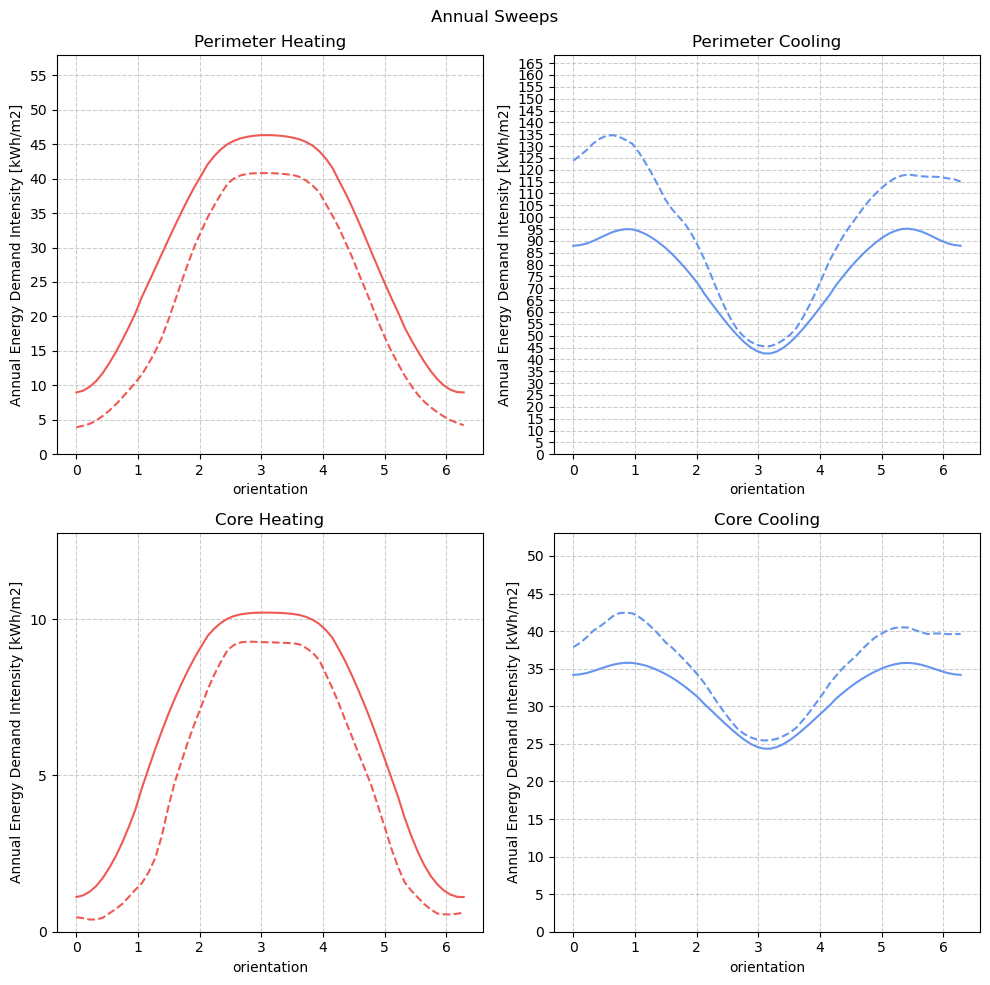

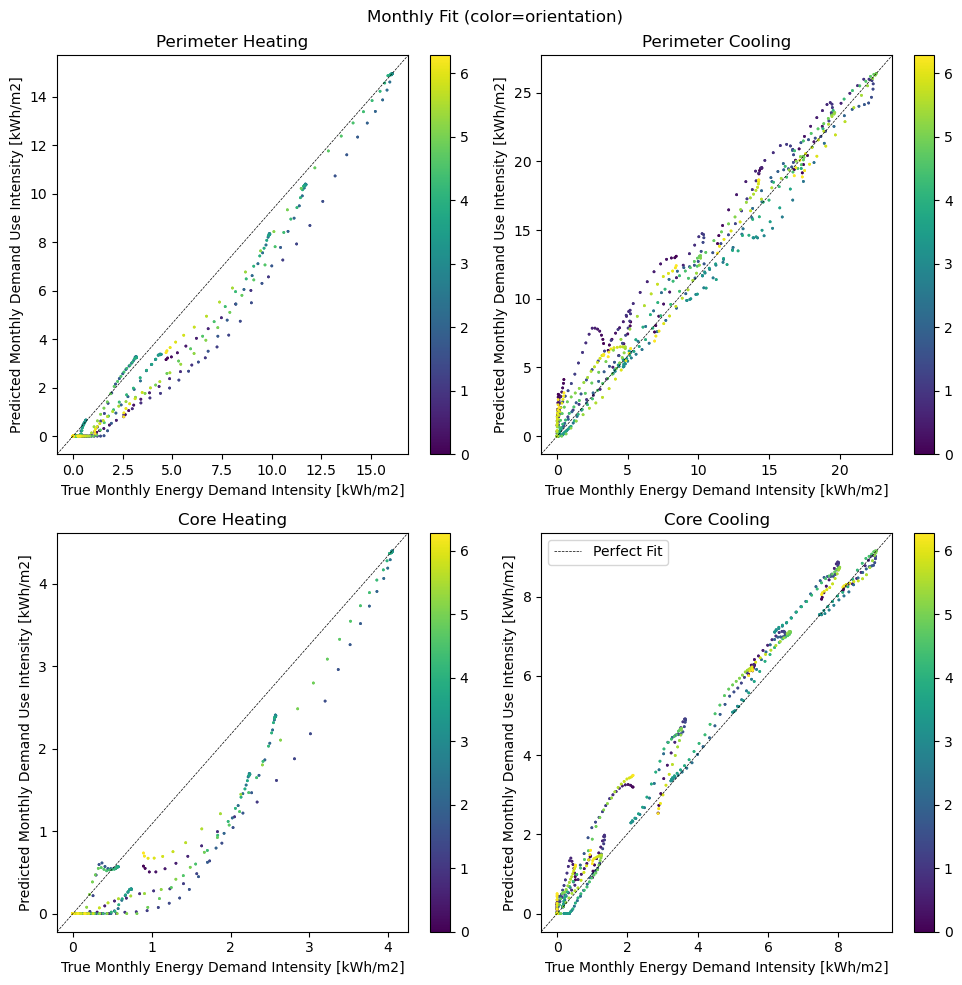

In [83]:
fig, axs = plt.subplots(2,2, figsize=(10,10))
for col, zone in [(0,"Perimeter"), (1,"Core")]:
    for row, end_use, color in [(0, "Heating", "#ef5954"),( 1, "Cooling", "#6595ef" )]:
        zone_use_true = results[zone][end_use].sum(axis=1)
        zone_use = shoebox_results[zone][end_use].sum(axis=1)
        axs[col,row].set_title(f"{zone} {end_use}")
        axs[col,row].plot(df[sweep_independent].values, zone_use_true, "-", label=f"EPlus", color=color)
        axs[col,row].plot(df[sweep_independent].values, zone_use, "--", label=f"Surrogate", color=color)
        axs[col,row].set_xlabel(sweep_independent)
        axs[col,row].set_ylabel("Annual Energy Demand Intensity [kWh/m2]")
        axs[col,row].set_ylim([0,1.25*max(zone_use_true.max(), zone_use.max())])
        # add grid lines every 5 units on y axis
        axs[col,row].yaxis.set_major_locator(MultipleLocator(5))
        # show grid lines
        axs[col,row].grid(which='major', color='#CCCCCC', linestyle='--')

plt.suptitle("Annual Sweeps")
fig.tight_layout()

fig, axs = plt.subplots(2,2, figsize=(10,10))
for col, zone in [(0,"Perimeter"), (1,"Core")]:
    for row, end_use, color in [(0, "Heating", "#ef5954"),( 1, "Cooling", "#6595ef" )]:
        zone_use_true = results[zone][end_use].values.flatten()
        zone_use = np.clip(shoebox_results[zone][end_use].values.flatten(),0,10000000)
        axs[col,row].set_title(f"{zone} {end_use}")
        axs[col,row].scatter(zone_use_true, zone_use,s=1, c=np.repeat(df[sweep_independent].values, 12))
        axs[col,row].set_xlabel("True Monthly Energy Demand Intensity [kWh/m2]")
        axs[col,row].set_ylabel("Predicted Monthly Demand Use Intensity [kWh/m2]")
        # show colorbar
        axs[col,row].plot([0, 1], [0, 1], transform=axs[col,row].transAxes, ls="--", c="k", lw=0.5, label="Perfect Fit")
        cbar = fig.colorbar(axs[col,row].scatter(zone_use_true, zone_use,s=1, c=np.repeat(df[sweep_independent].values, 12)))


plt.legend()
plt.suptitle(f"Monthly Fit (color={sweep_independent})")
fig.tight_layout()

